# Downloading Sentinel-1 Synthetic Aperture Radar (SAR)

References:
- https://planetarycomputer.microsoft.com/dataset/group/sentinel-1
- https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/sentinel-1-grd/sentinel-1-grd-example.ipynb
- https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/

In [6]:
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import numpy as np
import rich.table
from IPython.display import Image
import pandas as pd
import seaborn as sns

In [ ]:
# region of interest in South Florida
bbox_of_interest = [-80.6468, 25.8102, -80.4738, 25.9688]
bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
time_of_interest = "2025-02-01/2025-02-28"

# retrieve data from planetary computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-1-grd"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 9 Items


In [ ]:
# show most recent image
item = items[0]
Image(url=item.assets["rendered_preview"].href)

In [ ]:
# get metadata
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                       │
│ datetime                              │ 2025-02-26T01:54:27.866926Z      │
│ end_datetime                          │ 2025-02-26 01:54:40.365940+00:00 │
│ platform                              │ SENTINEL-1A                      │
│ s1:datatake_id                        │ 469815                           │
│ s1:instrument_configuration_ID        │ 7                                │
│ s1:orbit_source                       │ RESORB                           │
│ s1:processing_level                   │ 1                                │
│ s1:product_timeliness                 │ Fast-24h                         │
│ s1:resolution                         │ high                             │
│ s1:shape                              │ [25758, 16703]                   │
│ s1:slice_number                       │ 11                               │
│ s1:total_slices                       │ 13                               │
│ sar:center_frequency                  │ 5.405                            │
│ sar:frequency_band                    │ C                                │
│ sar:instrument_mode                   │ IW                               │
│ sar:looks_azimuth                     │ 1                                │
│ sar:looks_equivalent_number           │ 4.4                              │
│ sar:looks_range                       │ 5                                │
│ sar:observation_direction             │ right                            │
│ sar:pixel_spacing_azimuth             │ 10                               │
│ sar:pixel_spacing_range               │ 10                               │
│ sar:polarizations                     │ ['VV', 'VH']                     │
│ sar:product_type                      │ GRD                              │
│ sar:resolution_azimuth                │ 22                               │
│ sar:resolution_range                  │ 20                               │
│ sat:absolute_orbit                    │ 58061                            │
│ sat:orbit_state                       │ ascending                        │
│ sat:platform_international_designator │ 2014-016A                        │
│ sat:relative_orbit                    │ 64                               │
│ start_datetime                        │ 2025-02-26 01:54:15.367912+00:00 │
└───────────────────────────────────────┴──────────────────────────────────┘

In [ ]:
# get pixel data
vv = (
    rioxarray.open_rasterio(item.assets["vv"].href, overview_level=2)
    .astype(float)
    .squeeze()
)
vh = (
    rioxarray.open_rasterio(item.assets["vh"].href, overview_level=2)
    .astype(float)
    .squeeze()
)

c:\Users\szhan\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\planetary\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\szhan\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\planetary\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\szhan\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\planetary\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


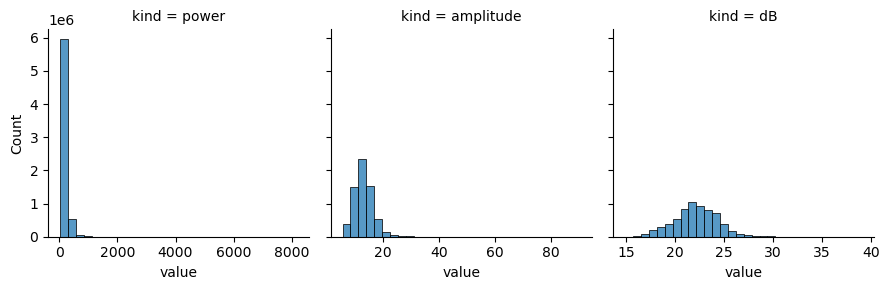

In [12]:
# plot distribution of pixel values
raw = vv.where(lambda x: x > 0).data.ravel()
df = (
    pd.DataFrame({"power": raw, "amplitude": np.sqrt(raw), "dB": 10 * np.log10(raw)})
    .dropna()
    .melt(value_vars=["power", "amplitude", "dB"], var_name="kind")
)

g = sns.FacetGrid(df, sharex=False, col="kind")
g.map(sns.histplot, "value", bins=30)

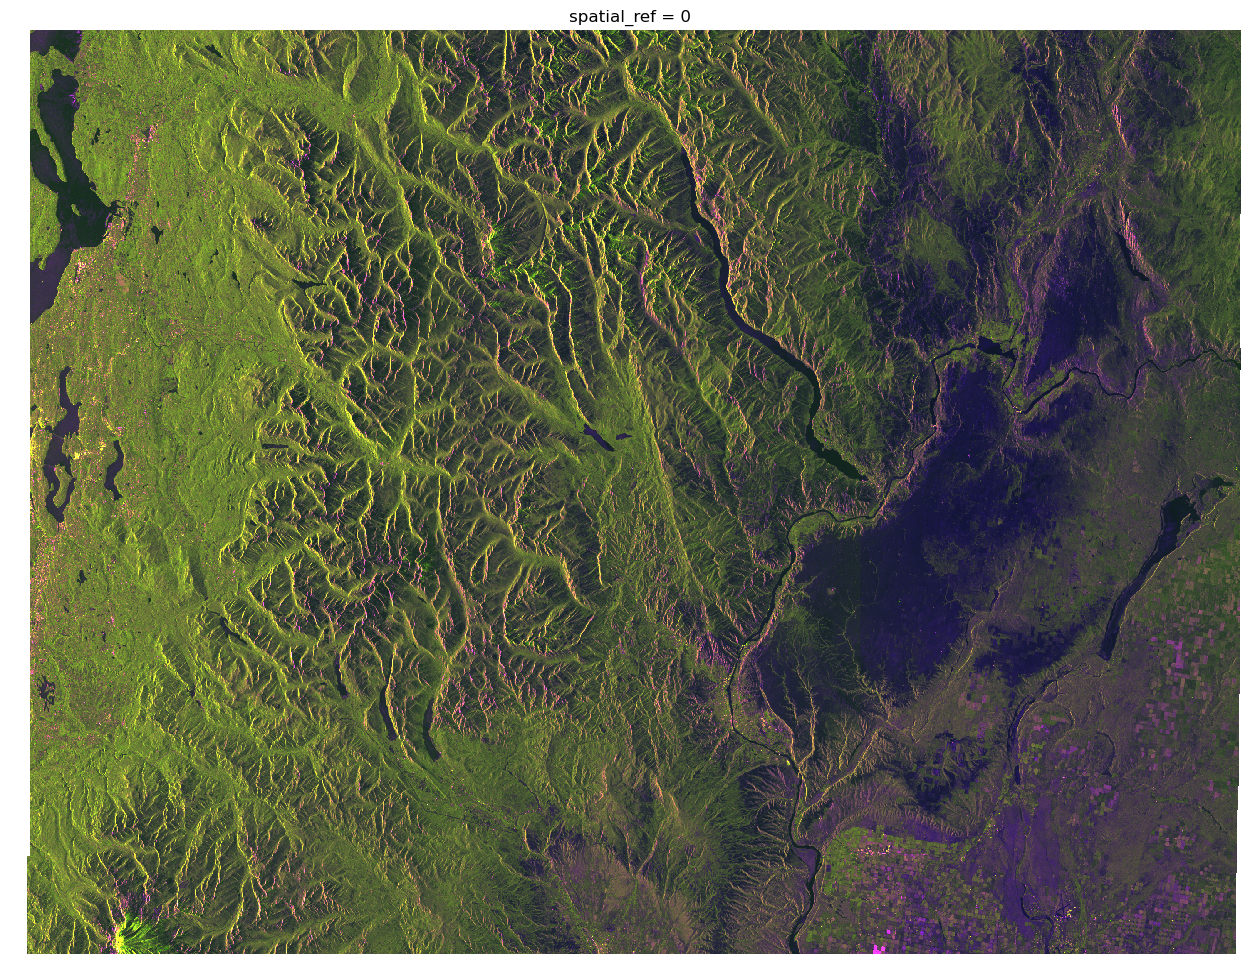

In [16]:
# show false color image (rescaled data)
r = vv / 600
g = vh / 270
b = (vv / vh) / 9
data = xr.concat([r, g, b], dim="band").clip(0, 1).where(lambda x: x > 0)
img = data.plot.imshow(rgb="band", size=12)
img.axes.set_axis_off()